In [1]:
import pandas as pd
import numpy as np
import random
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from pathlib import Path

In [2]:
# Unzip the dataset (assuming archive.zip is uploaded to Google drive )
zip_path = "/Users/home/Projects/multimodalRecommender/archive.zip"   # path to the zip file
extract_dir = "./dataset"  # folder where files will be extracted

# Create extract folder if not exists
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Dataset extracted to: {os.path.abspath(extract_dir)}")

# Check extracted contents
print("Top-level extracted files/folders:", os.listdir(extract_dir)[:10])

✅ Dataset extracted to: /Users/home/Projects/multimodalRecommender/dataset
Top-level extracted files/folders: ['images', 'styles.csv', 'myntradataset']


In [3]:
# Load dataset
dataset_path = "./dataset/styles.csv"  # Replace with your dataset path
data = pd.read_csv(dataset_path, on_bad_lines='skip')

# Display initial data overview
print("Dataset Overview:")
print(data.head())

# Clean missing values
data.dropna(subset=['gender', 'masterCategory', 'baseColour'], inplace=True)
data['baseColour'] = data['baseColour'].fillna('Unknown')

# Standardize column names
data.columns = [col.strip().lower() for col in data.columns]

# Check unique values for key features
print("\nUnique values in gender:", data['gender'].unique())
print("Unique values in season:", data['season'].unique())
print("Unique values in usage:", data['usage'].unique())


Dataset Overview:
      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  

Unique values in gender: ['Men' 'Women' 'Boys' 'Girls' 'Unisex']
Unique values in season: ['Fall' 'Summer' 'Wi

gender


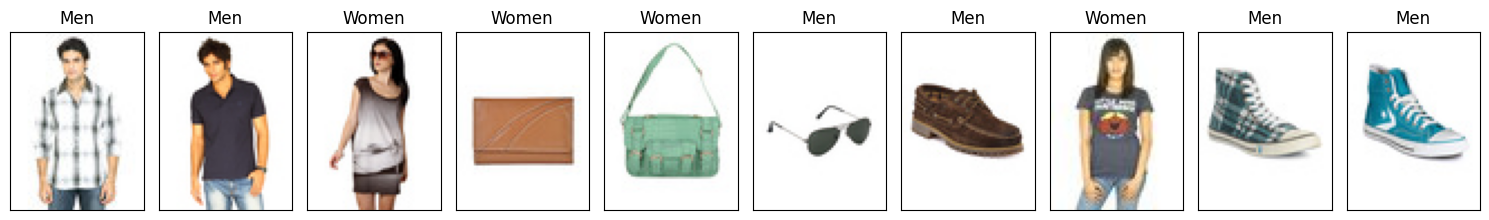

mastercategory


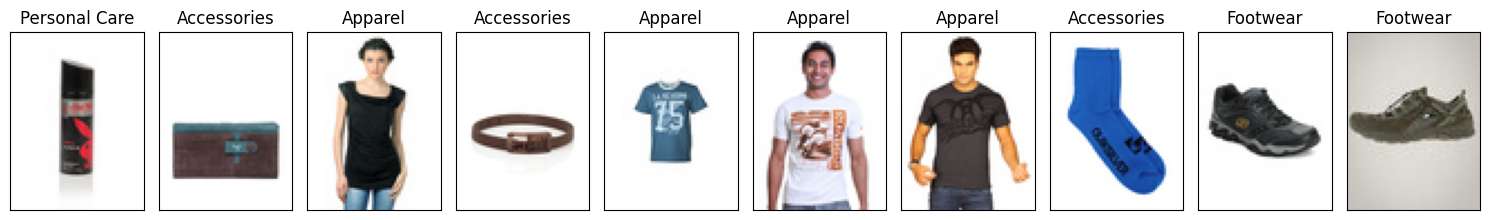

subcategory


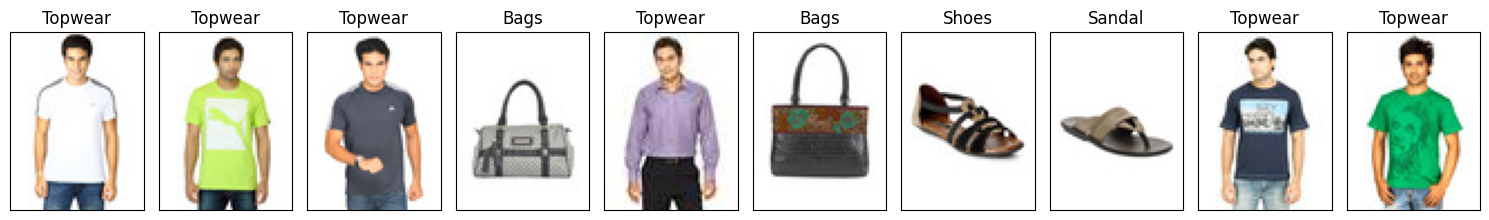

articletype


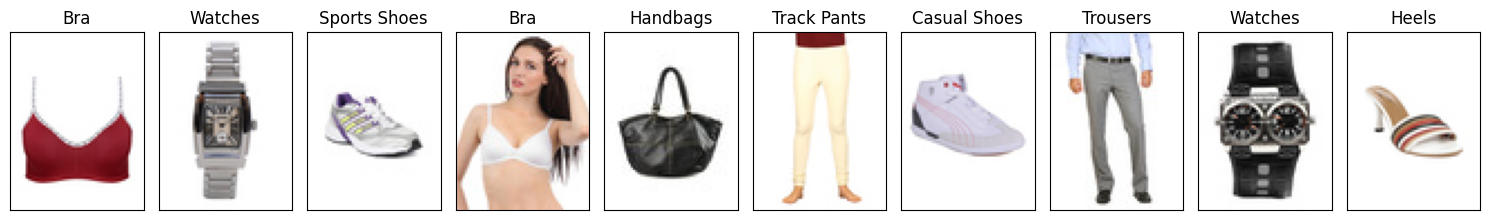

basecolour


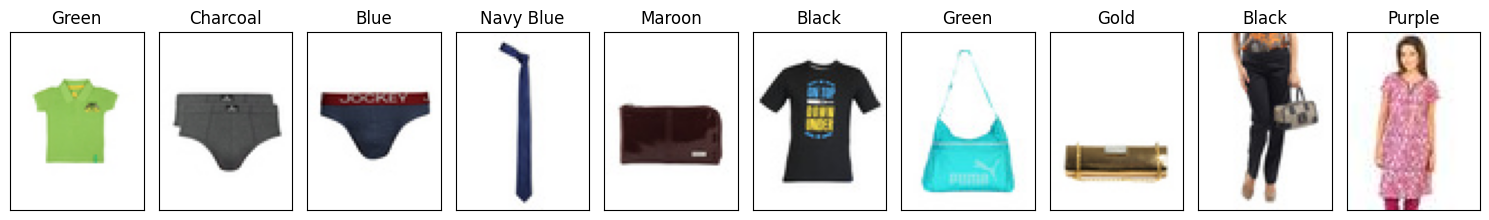

season


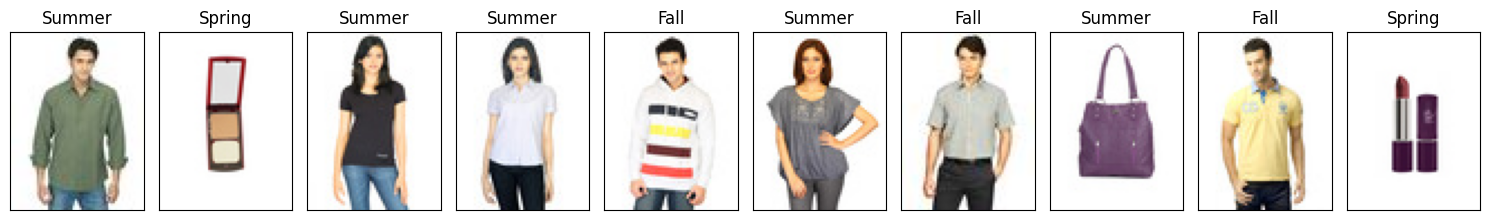

year


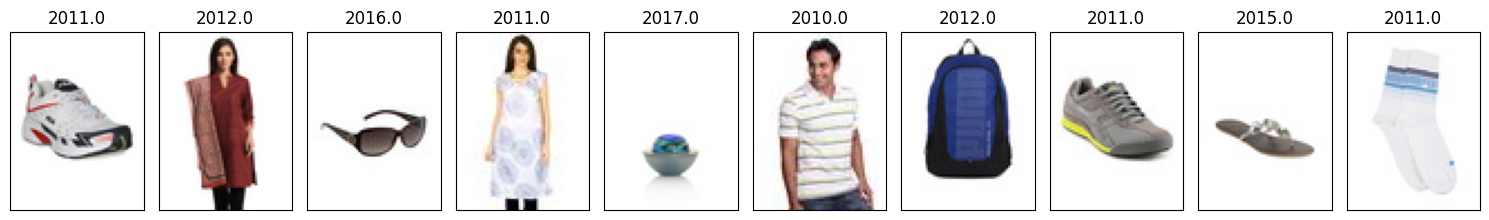

usage


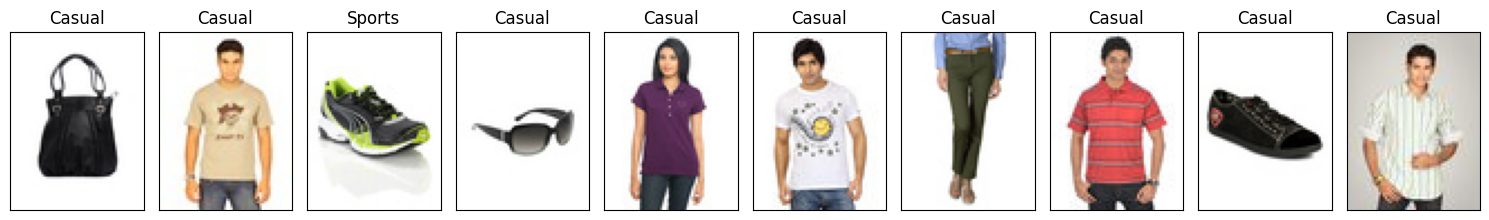

In [4]:
image_path = "./dataset/images"

def show_k_random(k, name):
    choices = np.random.choice(data.index, k, replace=False)
    choices = data.loc[choices, ['id', name]]
    fig, axs = plt.subplots(1, k, figsize=(15, 10))
    for this_name, id, ax in zip(choices[name], choices['id'], axs.ravel()):
        img_path = f"{image_path}/{id}.jpg"
        img = plt.imread(img_path)
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'{this_name}')
    plt.tight_layout()
    plt.show()

labels = data.columns[1:-1]
for col in labels:
    print(col)
    show_k_random(10, col)

In [5]:
def stratified_split_by_size(df, target_size, balance_columns=['mastercategory', 'subcategory', 'articletype'], random_state=42):
    """
    Split dataset into one stratified subset of target_size and remainder
    """
    np.random.seed(random_state)

    if target_size >= len(df):
        raise ValueError("Target size must be smaller than dataset size")

    # Create stratification key
    df_temp = df.copy()
    df_temp['_strata_key'] = df_temp[balance_columns].astype(str).agg('|'.join, axis=1)

    # Get unique strata and their proportions
    strata_counts = df_temp['_strata_key'].value_counts()
    strata_proportions = strata_counts / len(df_temp)

    # Sample proportionally from each stratum
    target_samples = []
    sampled_indices = []

    for stratum, proportion in strata_proportions.items():
        stratum_data = df_temp[df_temp['_strata_key'] == stratum]

        # Calculate how many samples to take from this stratum
        stratum_target = max(1, int(target_size * proportion))
        stratum_target = min(stratum_target, len(stratum_data))

        # Sample from this stratum
        if stratum_target > 0:
            stratum_sample = stratum_data.sample(n=stratum_target, random_state=random_state)
            target_samples.append(stratum_sample)
            sampled_indices.extend(stratum_sample.index.tolist())

    # Create target split
    target_split = pd.concat(target_samples, ignore_index=True)
    target_split = target_split.drop('_strata_key', axis=1)

    # Create remainder split
    remainder_split = df_temp.drop(sampled_indices).drop('_strata_key', axis=1).reset_index(drop=True)

    return target_split, remainder_split

# Create stratified sample
print("Creating stratified sample...")
df = data

# Assuming df is already loaded
balanced_sample, remainder = stratified_split_by_size(
    df,
    target_size=2000,
    balance_columns=['mastercategory', 'subcategory', 'articletype'],
    random_state=42
)

print(f"✓ Sample created:")
print(f"  - Balanced sample size: {len(balanced_sample)}")
print(f"  - Remainder size: {len(remainder)}")
print(f"  - Total: {len(balanced_sample) + len(remainder)}")

Creating stratified sample...
✓ Sample created:
  - Balanced sample size: 2016
  - Remainder size: 42393
  - Total: 44409


Creating visualization...


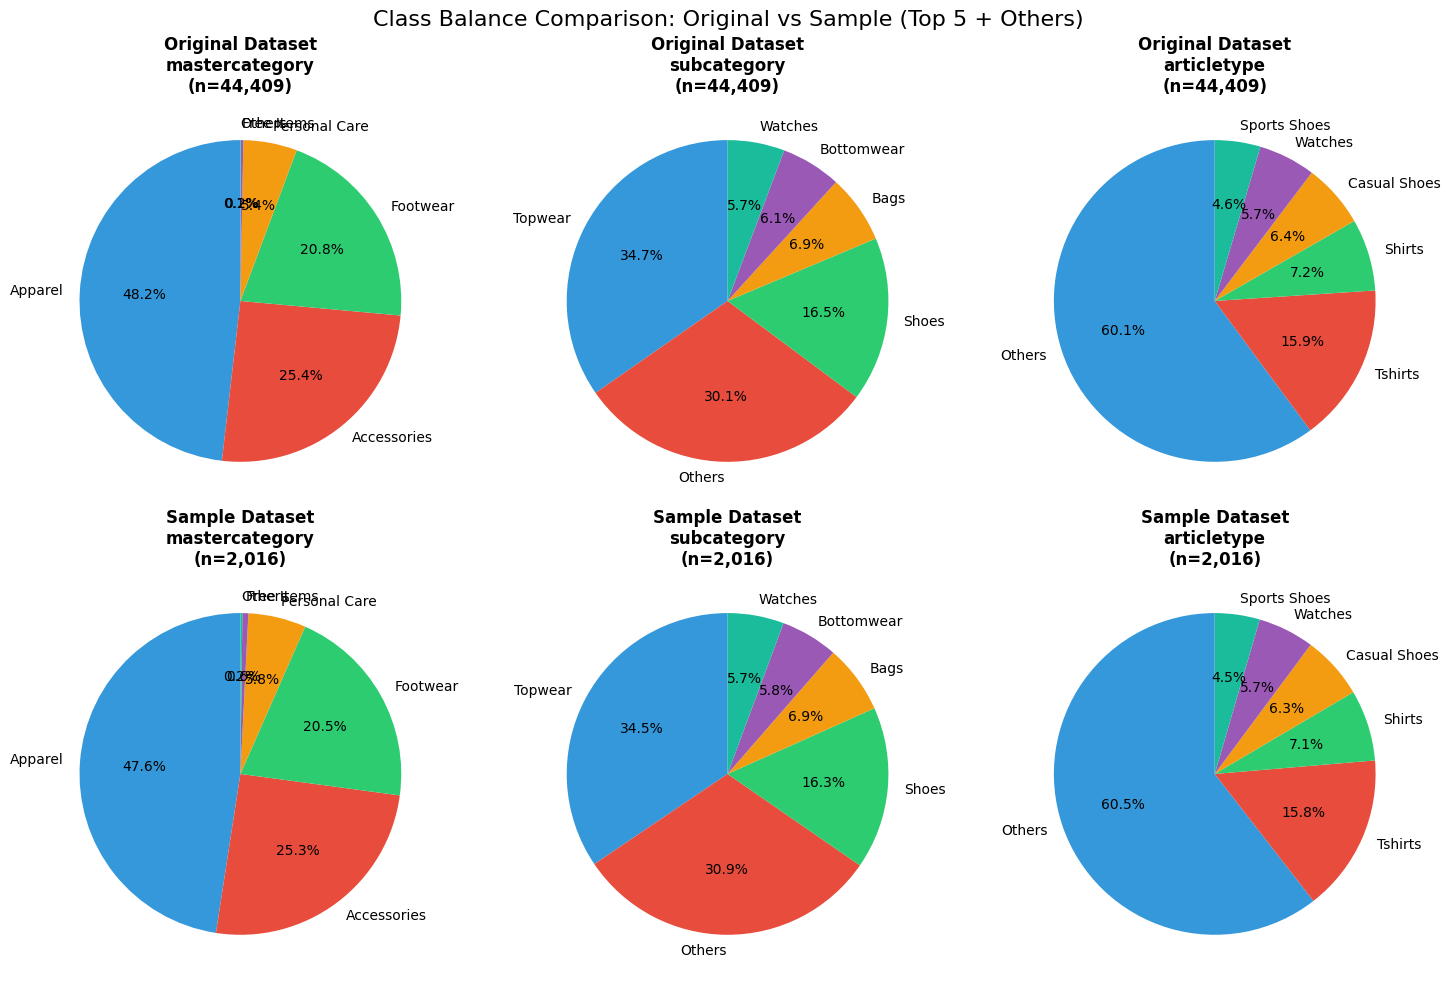

In [7]:
def prepare_data_for_visualization(df, columns=['masterCategory', 'subCategory', 'articleType'], top_k=7):
    """
    Prepare data for visualization by keeping only top K classes and grouping rest as 'Others'
    """
    df_viz = df.copy()

    for col in columns:
        # Get top K classes
        top_classes = df_viz[col].value_counts().head(top_k).index.tolist()

        # Replace non-top classes with 'Others'
        df_viz[col] = df_viz[col].apply(lambda x: x if x in top_classes else 'Others')

    return df_viz

def visualize_class_balance(original_df, sample_df,
                          columns=['masterCategory', 'subCategory', 'articleType'],
                          figsize=(15, 10), top_k=5):
    """
    Visualize and compare class balance between original dataset and sample
    Only shows top K classes, groups rest as 'Others'
    """

    # Prepare data for visualization
    original_viz = prepare_data_for_visualization(original_df, columns, top_k)
    sample_viz = prepare_data_for_visualization(sample_df, columns, top_k)

    n_cols = len(columns)
    fig, axes = plt.subplots(2, n_cols, figsize=figsize)
    fig.suptitle(f'Class Balance Comparison: Original vs Sample (Top {top_k} + Others)', fontsize=16, y=0.98)

    # If only one column, ensure axes is 2D
    if n_cols == 1:
        axes = axes.reshape(2, 1)

    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#34495e', '#e67e22', '#95a5a6']

    for i, col in enumerate(columns):
        # Original dataset distribution
        original_counts = original_viz[col].value_counts()

        # Sample dataset distribution
        sample_counts = sample_viz[col].value_counts()

        # Plot original
        axes[0, i].pie(original_counts.values,
                      labels=original_counts.index,
                      autopct='%1.1f%%',
                      colors=colors[:len(original_counts)],
                      startangle=90)
        axes[0, i].set_title(f'Original Dataset\n{col}\n(n={len(original_df):,})', fontweight='bold')

        # Plot sample
        axes[1, i].pie(sample_counts.values,
                      labels=sample_counts.index,
                      autopct='%1.1f%%',
                      colors=colors[:len(sample_counts)],
                      startangle=90)
        axes[1, i].set_title(f'Sample Dataset\n{col}\n(n={len(sample_df):,})', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Create and show visualization
print("Creating visualization...")

visualize_class_balance(
    df,
    balanced_sample,
    columns=['mastercategory', 'subcategory', 'articletype'],
    top_k=5
)

In [9]:
# Save sample to CSV
def save_sample_to_csv(sample_df, output_path="balanced_sample.csv"):
    """
    Save the balanced sample to CSV file
    """
    sample_df.to_csv(output_path, index=False)
    print(f"✓ Sample saved to: {output_path}")
    print(f"✓ Sample contains {len(sample_df)} records")
    return output_path

# Save the balanced sample
csv_path = save_sample_to_csv(balanced_sample, 'extractedData/balanced_styles_sample.csv')

# Show sample of the data
print("\nFirst 5 rows of saved sample:")
print(balanced_sample.head())

✓ Sample saved to: extractedData/balanced_styles_sample.csv
✓ Sample contains 2016 records

First 5 rows of saved sample:
      id gender mastercategory subcategory articletype basecolour  season  \
0  24050    Men        Apparel     Topwear     Tshirts       Blue    Fall   
1  13967    Men        Apparel     Topwear     Tshirts        Red    Fall   
2  10373    Men        Apparel     Topwear     Tshirts      Black    Fall   
3  50194   Boys        Apparel     Topwear     Tshirts      Black  Summer   
4  58372    Men        Apparel     Topwear     Tshirts      Beige  Summer   

     year   usage                                 productdisplayname  
0  2011.0  Casual                Locomotive Men Printed Blue T-shirt  
1  2011.0  Casual                   Ed Hardy Men Printed Red Tshirts  
2  2011.0  Casual  United Colors of Benetton Men Solid Black Tshirts  
3  2012.0  Casual                   Gini and Jony Boys Black T-shirt  
4  2012.0  Casual                       Locomotive Men Beige

In [10]:
# Fixed image extraction function
def extract_sample_images(sample_df, source_images_dir, output_images_dir, id_column='id'):
    """
    Extract images corresponding to sample IDs from source directory to output directory
    FIXED VERSION - properly handles .jpg files
    """

    # Create output directory if it doesn't exist
    Path(output_images_dir).mkdir(parents=True, exist_ok=True)

    source_path = Path(source_images_dir)
    output_path = Path(output_images_dir)

    print(f"Source directory: {source_path}")
    print(f"Output directory: {output_path}")
    print(f"Source directory exists: {source_path.exists()}")

    # Get list of IDs to extract
    ids_to_extract = sample_df[id_column].tolist()

    copied_count = 0
    not_found = []

    print(f"Looking for {len(ids_to_extract)} images...")

    for i, img_id in enumerate(ids_to_extract):
        # Since all files are JPGs, construct the filename directly
        source_file = source_path / f"{img_id}.jpg"

        if source_file.exists():
            # Copy image to output directory
            output_file = output_path / f"{img_id}.jpg"
            shutil.copy2(source_file, output_file)
            copied_count += 1

            # Print progress every 100 files
            if copied_count % 100 == 0:
                print(f"  Copied {copied_count} images so far...")
        else:
            not_found.append(img_id)

    print(f"\n✓ Image extraction completed:")
    print(f"  Successfully copied: {copied_count} images")
    print(f"  Not found: {len(not_found)} images")

    if not_found and len(not_found) <= 10:
        print(f"  Missing IDs: {not_found}")
    elif not_found:
        print(f"  First 10 missing IDs: {not_found[:10]}")

    return copied_count, not_found

# Update this path if needed
source_dir = "./dataset/images"

copied_count, not_found = extract_sample_images(
    balanced_sample,
    source_dir,
    "extractedData/balanced_sample_images",
    id_column='id'
)

if copied_count > 0:
    print(f"\n✓ SUCCESS: Extracted {copied_count} images")
    print(f"✓ Images saved to: extractedData/balanced_sample_images/")
    success_rate = (copied_count / len(balanced_sample)) * 100
    print(f"✓ Success rate: {success_rate:.1f}%")
else:
    print("\n✗ No images were extracted. Please check:")
    print("  1. Source directory path is correct")
    print("  2. Image files exist with .jpg extension")
    print("  3. ID column name matches your data")


Source directory: dataset/images
Output directory: extractedData/balanced_sample_images
Source directory exists: True
Looking for 2016 images...
  Copied 100 images so far...
  Copied 200 images so far...
  Copied 300 images so far...
  Copied 400 images so far...
  Copied 500 images so far...
  Copied 600 images so far...
  Copied 700 images so far...
  Copied 800 images so far...
  Copied 900 images so far...
  Copied 1000 images so far...
  Copied 1100 images so far...
  Copied 1200 images so far...
  Copied 1300 images so far...
  Copied 1400 images so far...
  Copied 1500 images so far...
  Copied 1600 images so far...
  Copied 1700 images so far...
  Copied 1800 images so far...
  Copied 1900 images so far...
  Copied 2000 images so far...

✓ Image extraction completed:
  Successfully copied: 2015 images
  Not found: 1 images
  Missing IDs: [12347]

✓ SUCCESS: Extracted 2015 images
✓ Images saved to: extractedData/balanced_sample_images/
✓ Success rate: 100.0%
